# Algorithm Performance

## Setup

In [1]:
from importlib import import_module
import json
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p

In [3]:
import bookgender.datatools as dt
from bookgender.config import data_dir
from bookgender.nbutils import *

In [4]:
init_figs('AlgoPerf')

using figure dir figures/AlgoPerf


## Load Performance Data

We need to collect all of the accuracy output files.

### Algorithm Eval Performance

In [5]:
perf_data = pd.read_csv('data/rec-perf.csv')
perf_data.head()

,MRR,HR,NDCG,DataSet,Algorithm
0,0.000301,0.0044,0.001089,BX-E,user-user
1,0.000556,0.0074,0.001804,BX-E,item-item
2,0.003905,0.0354,0.010269,BX-E,als
3,0.029221,0.1568,0.056760,BX-I,user-user
4,0.020828,0.0876,0.035883,BX-I,item-item


We would also like to bootstrap confidence intervals - this requires per-user statistics.

### Algorithm Tune Performance

In [6]:
tune_data = pd.read_json('data/rec-tune.json', orient='records', lines=True)
tune_data.head()

,params,iters,MRR,DataSet,Algorithm
0,"[67, 0.069343245462767]",20,0.000856,BX-E,user-user
1,"[232, 0.084880046234972]",20,0.000540,BX-E,item-item
2,"[297, 4.36979166769093, 4.927362178355647, 24....",20,0.002965,BX-E,als
3,"[303, 0.052267596581313004]",20,0.026312,BX-I,user-user
4,"[61, 0.03579462837616]",20,0.015321,BX-I,item-item


### Rerank Performance

In [7]:
rerank_data = pd.read_csv('data/rerank-perf.csv')
rerank_data.head()

,Strategy,MRR,HR,NDCG,DataSet,Algorithm
0,SingleEQ,0.000316,0.0046,0.001133,BX-E,user-user
1,GreedyEQ,0.000269,0.0044,0.001051,BX-E,user-user
2,GreedyReflect,0.000344,0.0050,0.001241,BX-E,user-user
3,SingleEQ,0.000359,0.0060,0.001286,BX-E,item-item
4,GreedyEQ,0.000447,0.0076,0.001638,BX-E,item-item


## Organize Runs

We have data sets, and we have implicit/explicit configurations.  For some data sets, these are encoded in the data set; for others, in the algorithm.

We need to split that out.

In [8]:
def normalize_runs(frame):
    frame = frame.assign(Implicit = frame['DataSet'].str.endswith('-I') | frame['Algorithm'].str.endswith('-imp'))
    frame['Algorithm'] = frame['Algorithm'].str.replace('-imp', '')
    frame['DataSet'] = frame['DataSet'].str.replace('-[IE]', '')
    frame['Algorithm'] = frame['Algorithm'].str.replace('wrls', 'als').str.upper()
    frame['Algorithm'] = frame['Algorithm'].str.replace(r'(\w)\w+-(\w)\w+', r'\1\2')
    return frame

In [9]:
perf_data = normalize_runs(perf_data)

And look at that data:

In [10]:
perf_data

,MRR,HR,NDCG,DataSet,Algorithm,Implicit
0,0.000301,0.0044,0.001089,BX,UU,False
1,0.000556,0.0074,0.001804,BX,II,False
2,0.003905,0.0354,0.010269,BX,ALS,False
3,0.029221,0.1568,0.056760,BX,UU,True
4,0.020828,0.0876,0.035883,BX,II,True
5,0.030019,0.1522,0.057322,BX,ALS,True
6,0.017138,0.1004,0.034448,BX,BPR,True
7,0.000043,0.0008,0.000183,AZ,UU,False
8,0.003357,0.0246,0.007375,AZ,II,False
9,0.000221,0.0036,0.000879,AZ,ALS,False


In [11]:
tune_data = normalize_runs(tune_data)
tune_data

,params,iters,MRR,DataSet,Algorithm,Implicit
0,"[67, 0.069343245462767]",20,0.000856,BX,UU,False
1,"[232, 0.084880046234972]",20,0.000540,BX,II,False
2,"[297, 4.36979166769093, 4.927362178355647, 24....",20,0.002965,BX,ALS,False
3,"[303, 0.052267596581313004]",20,0.026312,BX,UU,True
4,"[61, 0.03579462837616]",20,0.015321,BX,II,True
5,"[499, 0.151451427679924, 0.06685861681803601, ...",20,0.026321,BX,ALS,True
6,"[249, 0.011980259542217, 0.09697898418796101]",20,0.014692,BX,BPR,True
7,"[68, 0.070821028781701]",20,0.000306,AZ,UU,False
8,"[5, 0.1]",20,0.002919,AZ,II,False
9,"[299, 0.027209462059128, 0.09593544705902601, ...",100,0.000533,AZ,ALS,False


## Accuracy Plots

Plot the MRR for each data set!

In [12]:
merged_mrr = pd.concat([
    tune_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].assign(Stage='Tune'),
    perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].assign(Stage='Eval')
], ignore_index=True)
merged_mrr['Mode'] = 'Explicit'
merged_mrr.loc[merged_mrr['Implicit'], 'Mode'] = 'Implicit'
merged_mrr.head()

,DataSet,Algorithm,Implicit,MRR,Stage,Mode
0,BX,UU,False,0.000856,Tune,Explicit
1,BX,II,False,0.000540,Tune,Explicit
2,BX,ALS,False,0.002965,Tune,Explicit
3,BX,UU,True,0.026312,Tune,Implicit
4,BX,II,True,0.015321,Tune,Implicit


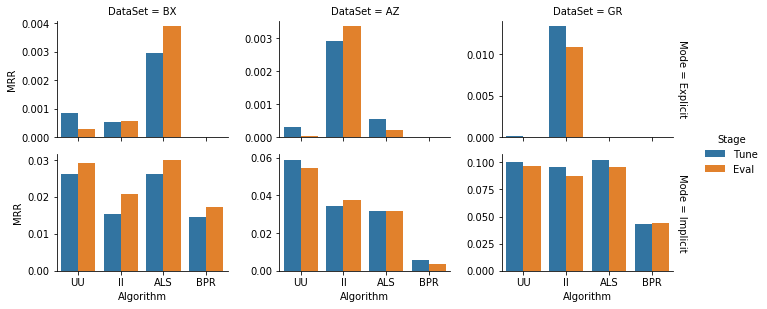

In [13]:
sns.catplot(x='Algorithm', y='MRR', row='Mode', col='DataSet', hue='Stage', data=merged_mrr, kind='bar',
            sharey=False, margin_titles=True, aspect=1.5, height=2.2)

/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/AlgoPerf/rec-perf.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


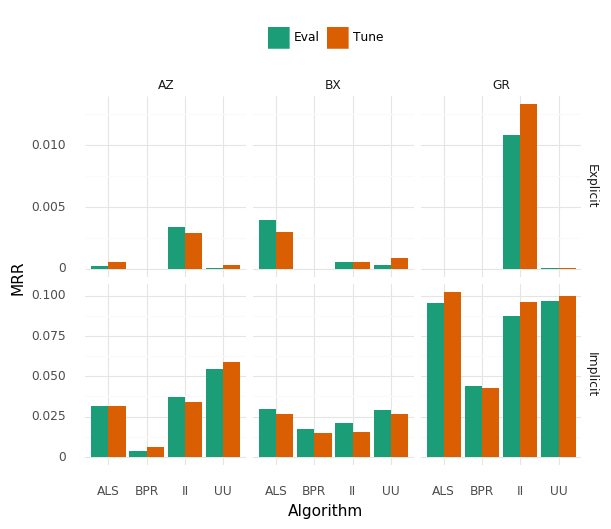

<ggplot: (8746721886361)>

In [14]:
make_plot(merged_mrr, p.aes(x='Algorithm', y='MRR', fill='Stage'),
          p.geom_bar(stat='identity', position='dodge'),
          p.facet_grid('Mode ~ DataSet', scales='free_y'),
          p.scale_fill_brewer('qual', 'Dark2'),
          file='rec-perf.pdf', width=7, height=4, legend_position='top', legend_title=p.element_blank())

In [15]:
print(perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].set_index(['DataSet', 'Implicit', 'Algorithm']).unstack().to_latex())

\begin{tabular}{llrrrr}
\toprule
   & {} & \multicolumn{4}{l}{MRR} \\
   & Algorithm &       ALS &       BPR &        II &        UU \\
DataSet & Implicit &           &           &           &           \\
\midrule
AZ & False &  0.000221 &       NaN &  0.003357 &  0.000043 \\
   & True  &  0.031726 &  0.003825 &  0.037334 &  0.054445 \\
BX & False &  0.003905 &       NaN &  0.000556 &  0.000301 \\
   & True  &  0.030019 &  0.017138 &  0.020828 &  0.029221 \\
GR & False &       NaN &       NaN &  0.010818 &  0.000062 \\
   & True  &  0.095640 &  0.044103 &  0.087541 &  0.096567 \\
\bottomrule
\end{tabular}



And hit rate:

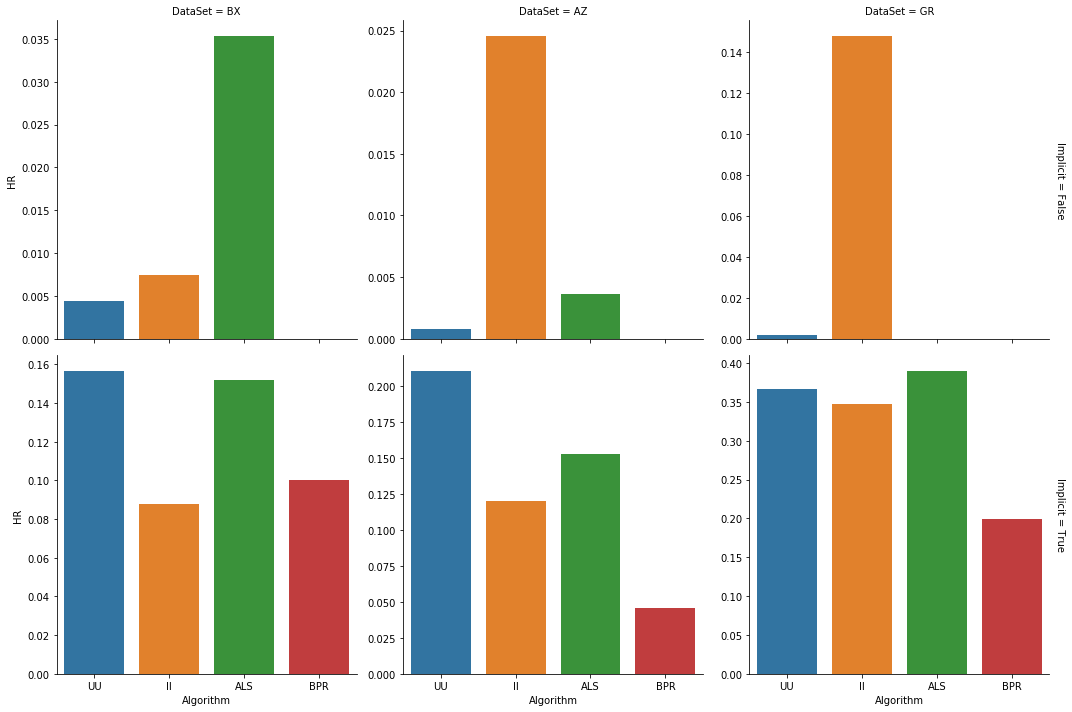

In [16]:
sns.catplot(x='Algorithm', y='HR', row='Implicit', col='DataSet', data=perf_data, kind='bar', 
            sharey=False, margin_titles=True)

## Rerank Loss

In [17]:
rerank_data = normalize_runs(rerank_data)
rerank_data.head()

,Strategy,MRR,HR,NDCG,DataSet,Algorithm,Implicit
0,SingleEQ,0.000316,0.0046,0.001133,BX,UU,False
1,GreedyEQ,0.000269,0.0044,0.001051,BX,UU,False
2,GreedyReflect,0.000344,0.0050,0.001241,BX,UU,False
3,SingleEQ,0.000359,0.0060,0.001286,BX,II,False
4,GreedyEQ,0.000447,0.0076,0.001638,BX,II,False


In [18]:
rr_mrr = pd.concat([
    perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR', 'HR']].assign(Strategy='Raw'),
    rerank_data[['DataSet', 'Algorithm', 'Implicit', 'MRR', 'HR', 'Strategy']]
], ignore_index=True)
rr_mrr.head()
rr_mrr['Mode'] = 'Explicit'
rr_mrr.loc[rr_mrr['Implicit'], 'Mode'] = 'Implicit'
rr_mrr['Strategy'] = rr_mrr['Strategy'].astype('category').cat.reorder_categories(['Raw', 'SingleEQ', 'GreedyEQ', 'GreedyReflect'])
rr_mrr.head()

,DataSet,Algorithm,Implicit,MRR,HR,Strategy,Mode
0,BX,UU,False,0.000301,0.0044,Raw,Explicit
1,BX,II,False,0.000556,0.0074,Raw,Explicit
2,BX,ALS,False,0.003905,0.0354,Raw,Explicit
3,BX,UU,True,0.029221,0.1568,Raw,Implicit
4,BX,II,True,0.020828,0.0876,Raw,Implicit


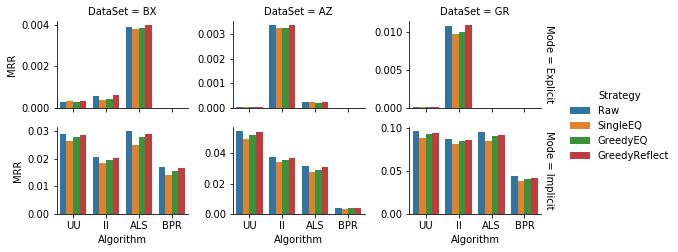

In [19]:
sns.catplot(x='Algorithm', y='MRR', row='Mode', col='DataSet', hue='Strategy', data=rr_mrr, kind='bar',
            sharey=False, margin_titles=True, aspect=1.5, height=1.8)
# plt.savefig(fig_dir / 'rerank-perf.pdf')

/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/AlgoPerf/rerank-perf.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


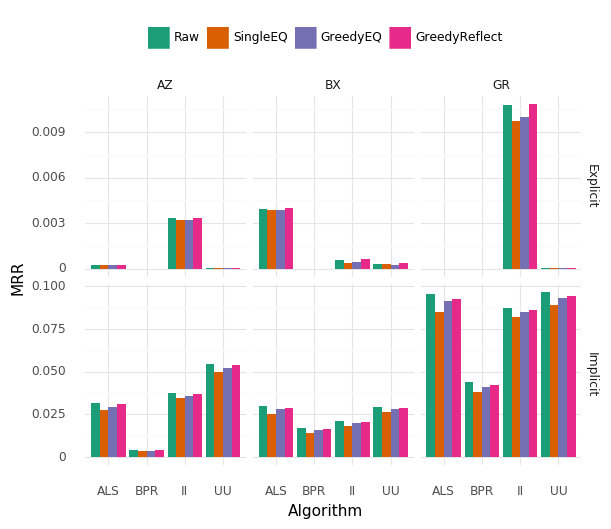

<ggplot: (8746716406401)>

In [20]:
make_plot(rr_mrr, p.aes(x='Algorithm', y='MRR', fill='Strategy'),
          p.geom_bar(stat='identity', position='dodge'),
          p.facet_grid('Mode ~ DataSet', scales='free_y'),
          p.scale_fill_brewer('qual', 'Dark2'),
          file='rerank-perf.pdf', width=7, height=4, legend_position='top', legend_title=p.element_blank())

In [21]:
penalty = (perf_data.set_index(['DataSet', 'Implicit', 'Algorithm']).MRR - \
   rerank_data.set_index(['DataSet', 'Implicit', 'Algorithm', 'Strategy']).MRR) / perf_data.set_index(['DataSet', 'Implicit', 'Algorithm']).MRR

In [22]:
print(penalty.unstack().to_latex(float_format=lambda f: '{:.2f}%'.format(f*100)))

\begin{tabular}{lllrrr}
\toprule
   &       & Strategy &  GreedyEQ &  GreedyReflect &  SingleEQ \\
DataSet & Implicit & Algorithm &           &                &           \\
\midrule
AZ & False & ALS &     3.23\% &         -0.57\% &    -5.60\% \\
   &       & II &     3.65\% &         -0.01\% &     3.72\% \\
   &       & UU &   -10.23\% &          0.85\% &   -10.23\% \\
   & True  & ALS &     8.11\% &          2.63\% &    13.09\% \\
   &       & BPR &     6.18\% &         -0.98\% &    10.32\% \\
   &       & II &     5.08\% &          1.34\% &     7.60\% \\
   &       & UU &     4.65\% &          1.08\% &     8.69\% \\
BX & False & ALS &     0.82\% &         -2.24\% &     1.72\% \\
   &       & II &    19.48\% &        -10.85\% &    35.42\% \\
   &       & UU &    10.70\% &        -14.50\% &    -5.12\% \\
   & True  & ALS &     6.89\% &          3.59\% &    15.99\% \\
   &       & BPR &     8.09\% &          3.08\% &    16.76\% \\
   &       & II &     5.56\% &          2.46\% &    12.